# Classification using Transformer  


This problem does have existing solutions using CNN architectures such as:
Convolution2D, Maxpooling2D, GlobalAveragePooling 2D. Other solutions use Softmax layers, Sequential layers and Basic Dropout or Flatten and Activation layers. However, the maximum accuracy can still be improved using the existing solutions. In case, modifying the current solutions does not make much of a difference, the next step would be building a new pipeline of preprocessing and training of the classifier. 

## Loading Libraries

Before starting you will need to import the libraries that are needed.

In [1]:
import numpy as np
import pandas as pd

#The following libraries are for plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# These are for audio feature detection
import librosa
import librosa.display

# For accesing directories of file and keeping time
import os
import time
import random

# For image processing
from PIL import Image

#Creating report of training
from sklearn.metrics import classification_report

# For training
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

If you are running in a local system with access to a GPU, you can consider changing this to True.

In [2]:
# GPU access (for local systems)
USE_GPU = True

You should work in the same directory where you downloaded the dataset. After defining the home directories, we test if we can access some of the files.

In [3]:
#Defining home directory of urbansound files
home_directory = 'D:/MLProject/'
metadata = pd.read_csv(home_directory + 'UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


We also compute the 'duration' field, substracting the start and end times.

In [4]:
metadata['duration'] = metadata['end'] - metadata['start']
metadata['duration'].describe()

count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64

We also test the access to the audio files with the librosa library and load any of them.\
For this file, we can get the sample rate.

In [5]:
# for testing librosa.load
test_file = home_directory + 'UrbanSound8K/audio/fold5/100263-2-0-117.wav'
y, sr = librosa.load(test_file)
print('Sample rate: ' + str(sr))

Sample rate: 22050


To analize the data, we can plot the audiofile. 

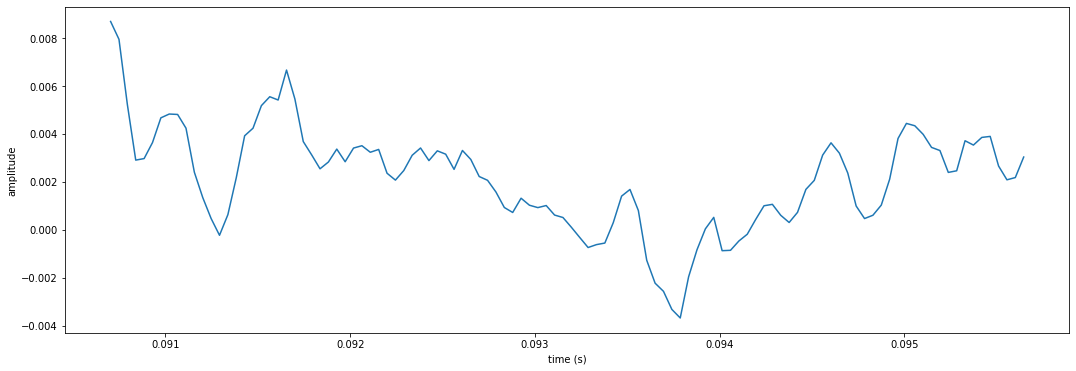

In [6]:
# displaying audio file in graph

#Create an images directory. 
if not os.path.exists('images'):
    os.makedirs('images')

file_time = np.arange(0, len(y)) / sr

plt.figure(figsize=(18, 6))
plt.plot(file_time[2000:2110], y[2000:2110])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.savefig(home_directory + 'images/sample_wave.png')

We can also plot the STFT feature extracted from audio file, converted to decibles.

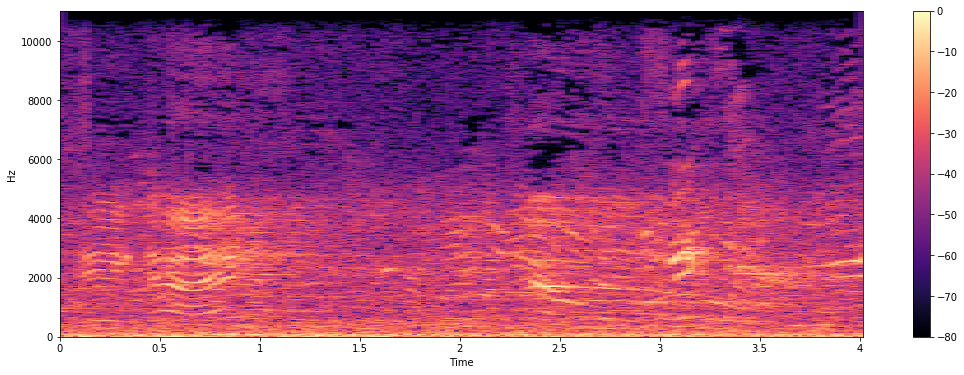

In [7]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(np.abs(Y), ref=np.max)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.savefig(home_directory + 'images/example_spectrogram.png')

Plot the same with **axis log scale**

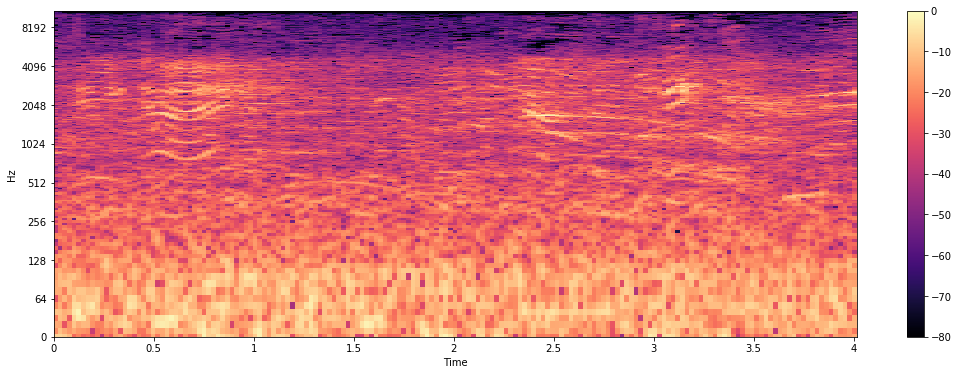

In [14]:
# Plot the same with axis log scale
plt.figure(figsize=(18, 6))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.savefig(home_directory + 'images/example_log_spectrogram.png')

Plotting melspectogram in db.

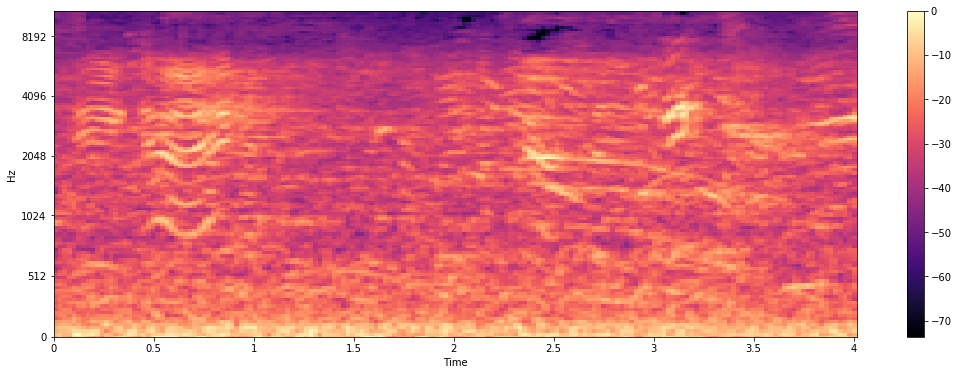

In [8]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128, fmax=8000)
Sdb = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(18, 6))
librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.savefig(home_directory + 'images/example_mel_spectrogram.png')

## Creating directories for processed data

To save all the processed data, we will proceed to create some directories

In [10]:
#Creating other required directories
parent_directory = home_directory + 'UrbanSound8K/audio/'
numpy_save_directory = home_directory + 'UrbanSound8K/processed_np/'
model_save_directory = home_directory + 'models/'

if not os.path.exists(numpy_save_directory):
    os.makedirs(numpy_save_directory)
    
sub_dirs = ['fold' + str(x) for x in np.arange(1,11)]

for sub_dir in sub_dirs:
    if not os.path.exists(numpy_save_directory + sub_dir):
        os.makedirs(numpy_save_directory + sub_dir)
        
if not os.path.exists(model_save_directory):
    os.makedirs(model_save_directory)

## Declaring parameters and functions 

In [ ]:
# Detection parameters for melspectograms from audio files
melspec_params = {
    'n_mels': 128,
    'duration': 4*22050,
    'hop_length': 512,
    'n_fft': 2048,
    'fmin': 20
}

# Function for loading and trimming file for db limits and also trimming them down to the duration lengths.
def load_audio(params, file_path):
    y, sr = librosa.load(parent_directory + sub_dir + '/' + file_list[i])

    # clip silence
    yt, index = librosa.effects.trim(y, top_db=60)       

    # pad to a length of 4s
    if len(yt) > params['duration']:
        yt = yt[:params['duration']]
    else:
        padding = params['duration'] - len(yt)
        offset = padding // 2
        yt = np.pad(yt, (offset, params['duration'] - len(yt) - offset), 'constant')
    
    return yt, sr

# Function for extracting melspectograms from audio files
def create_melspec(params, audio_data, sampling_rate):
    S = librosa.feature.melspectrogram(audio_data, 
                                       sr=sampling_rate, 
                                       n_mels=params['n_mels'],
                                       hop_length=params['hop_length'],
                                       n_fft=params['n_fft'],
                                       fmin=params['fmin'],
                                       fmax=(sampling_rate // 2))
    Sb = librosa.power_to_db(S, ref=np.max)
    Sb = Sb.astype(np.float32)
    
    return Sb


# Function for modifying every audio file's melspectogram from mono to original colours        
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    
    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
        
    return V  


# Displaying the spectogrmas (not necessary to use)
def display_melspec(params, mels, sampling_rate): 
    librosa.display.specshow(mels, x_axis='time', y_axis='mel',
                             sr=sampling_rate, hop_length=params['hop_length'],
                             fmin=params['fmin'], fmax=(sampling_rate // 2))
    plt.colorbar()
    plt.show()

## Getting the melspectogram of the audiofiles 

We loop through the directory and derive the melspectogram for all audio files and saving them in numpy format in another directory. This step takes a lot of time.


In [22]:
for sub_dir in sub_dirs:
    file_list = os.listdir(parent_directory + sub_dir)
    file_list = [x for x in file_list if 'wav' in x]
    file_labels = [int(x.split('-')[1]) for x in file_list]
    print('processing {}'.format(sub_dir))
    
    for i in range(0, len(file_list)):
        y, sr = load_audio(melspec_params, parent_directory + sub_dir + '/' + file_list[i])
        melspec = create_melspec(melspec_params, y, sr)
        melspec_color = mono_to_color(melspec)
        np.savez(numpy_save_directory + sub_dir + '/' + file_list[i][:-4], melspec_color)

processing fold1
processing fold2
processing fold3
processing fold4
processing fold5
processing fold6
processing fold7
processing fold8
processing fold9
processing fold10


Creation of a class with melspectograms and labels from csv files and also indexing itself.

In [23]:
# Embedding  class 
class TrainDataset(Dataset):
    def __init__(self, melspecs, labels, transforms):
        super().__init__()
        self.melspecs = melspecs
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.melspecs)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.melspecs[idx], mode='RGB')        
        image = self.transforms(image).div_(255)       
        label = self.labels[idx]
        
        return image, label

## Training model

In [24]:
# Assigning parameters to the training model (to be used later)
transforms_dict = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ])
}

The primary convolutional block is created as a class with self embedded dimensions. Layers like Conv2D, Relu BatchNorm2D and Sequential are used. Then onwards, the initial weights and carry forward weights are defined.

In [25]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

Finally the classification  module is defined, number of classes set to 10. Then Layers were embedded to the class object and a forward sequence was created.


In [26]:
class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x


In [27]:
# Training parameters are defined
model_params = {
    'num_epochs': 50, 
    'batch_size': 64,
    'learning_rate': 0.001,
    'num_clases': 10, 
    'eta_min': 1e-5,
    't_max': 10
}

In [28]:
# Random seeds are generated by this function in order to make the training exclusive
def set_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if USE_GPU:
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 73
set_seeds(SEED)

Training and testing is done, and the scores are recorded for each epoch and finally after every fold, again the summaries are printed, and finally the best and average results are printed.


In [ ]:
oof_labels = []
oof_preds = []

for sub_dir in sub_dirs:
    X_train = []
    train_labels = []
    X_valid = [] 
    valid_labels = [] 
    
    for fold in sub_dirs:
        file_list = os.listdir(numpy_save_directory + fold)
        if fold == sub_dir:
            for file_name in file_list:
                with np.load(numpy_save_directory + fold + '/' + file_name) as f:
                    X_valid.append(f['arr_0'])
                valid_labels.append(int(file_name.split('-')[1]))
                y_valid = np.zeros((len(valid_labels), 10)).astype(int)
                for i, j in enumerate(valid_labels):
                    y_valid[i, j] = 1
        else:
            for file_name in file_list:
                with np.load(numpy_save_directory + fold + '/' + file_name) as f:
                    X_train.append(f['arr_0'])
                train_labels.append(int(file_name.split('-')[1]))
                y_train = np.zeros((len(train_labels), 10)).astype(int)
                for i, j in enumerate(train_labels):
                    y_train[i, j] = 1

    train_dataset = TrainDataset(X_train, train_labels, transforms_dict['train'])
    valid_dataset = TrainDataset(X_valid, valid_labels, transforms_dict['train'])

    train_loader = DataLoader(train_dataset, batch_size=model_params['batch_size'], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=model_params['batch_size'], shuffle=False)
    
    if USE_GPU:
        model = Classifier().cuda()
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        model = Classifier()
        criterion = nn.CrossEntropyLoss()
    
    optimizer = Adam(params=model.parameters(), lr=model_params['learning_rate'], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=model_params['t_max'], eta_min=model_params['eta_min'])
    
    mb = master_bar(range(model_params['num_epochs']))
    
    for epoch in mb:
        start_time = time.time()
        model.train()
        avg_loss = 0.

        for x_batch, y_batch in progress_bar(train_loader, parent=mb):
            if USE_GPU:
                preds = model(x_batch.cuda())
                loss = criterion(preds, y_batch.cuda())
            else:
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(train_loader)

        model.eval()
        valid_preds = np.zeros((len(X_valid), 10))
        avg_val_loss = 0.

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            if USE_GPU:
                preds = model(x_batch.cuda()).detach()
                loss = criterion(preds, y_batch.cuda())
            else:
                preds = model(x_batch).detach()
                loss = criterion(preds, y_batch)

            preds = torch.sigmoid(preds)
            valid_preds[i * model_params['batch_size']: (i+1) * model_params['batch_size']] = preds.cpu().numpy()

            avg_val_loss += loss.item() / len(valid_loader)

        accuracy = sum(1 for x,y in zip(valid_labels, valid_preds.argmax(axis=1).tolist()) if x == y) / len(valid_labels)    
            
        scheduler.step()
        
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  accuracy: {accuracy:.4f}  time: {elapsed:.0f}s')
            
        if epoch == 0:
            best_accuracy = accuracy
            torch.save(model.state_dict(), home_directory + 'models/' + sub_dir + '_best_model.pt')
            best_preds = valid_preds.argmax(axis=1).tolist()
        else:
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), home_directory + 'models/' + sub_dir + '_best_model.pt')
                best_preds = valid_preds.argmax(axis=1).tolist()
    
    print(sub_dir + ' summary')
    print('------------------------')
    print(classification_report(np.argmax(valid_preds, axis=1), valid_labels))
    print('------------------------')
    print('best accuracy: ' + str(best_accuracy))
    print('------------------------')
    print('\n')

    oof_labels.append(valid_labels)
    oof_preds.append(best_preds)


oof_labels_flat = [item for sublist in oof_labels for item in sublist]
oof_preds_flat = [item for sublist in oof_preds for item in sublist]

oof_accuracy = sum(1 for x, y in zip(oof_labels_flat, oof_preds_flat) if x == y) / len(oof_labels_flat)

print('------------------------')
print('out-of-fold prediction accuracy: ' + str(oof_accuracy))

The out - of - fold accuracy and the mean of all those out - of - fold accuracies are printed.

In [ ]:
oof_accuracy = []
for i in range(len(oof_preds)):
    preds = oof_preds[i]
    labels = oof_labels[i]
    oof_accuracy.append(sum(1 for x, y in zip(labels, preds) if x == y) / len(labels))

print('Mean Out-of-Fold Prediction Accuracy: ' + str(np.mean(oof_accuracy)))
print('Out-of-Fold Prediction Accuracy Standard Deviation: ' + str(np.std(oof_accuracy)))

Mean Out-of-Fold Prediction Accuracy: nan
Out-of-Fold Prediction Accuracy Standard Deviation: nan


c:\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\python38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\python38\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\python38\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Confusion matrix

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


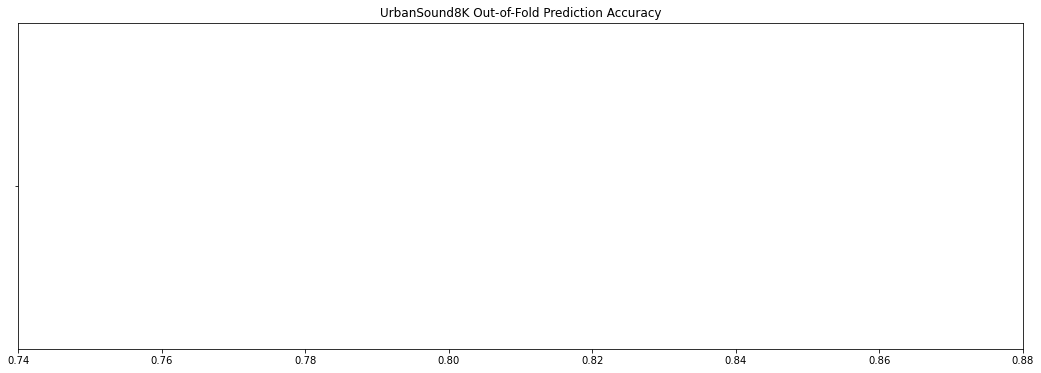

In [ ]:
#Confusion matrix is displayed.
plt.figure(figsize=(18, 6))
sns.boxplot(oof_accuracy)
plt.xlim(0.74, 0.88)
plt.title('UrbanSound8K Out-of-Fold Prediction Accuracy')
plt.savefig(home_directory + 'images/oof_pred_acc.png')
plt.show()